# Seminar 10: Artificial neural networks, MLP, PyTorch
Machine Learning by professor Evgeny Burnaev

The goal of this seminar is to get familiar with how neural networks work and PyTorch framework using a toy MLP and MNIST clasification problem. The plan of the seminar is:
1. Step-by-step writing of MLP using NumPy,
2. Rewriting it in PyTorch,
3. Training MLP to classify MNIST digits.

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

%matplotlib inline

## Act 1: Multilayer perceptron on NumPy

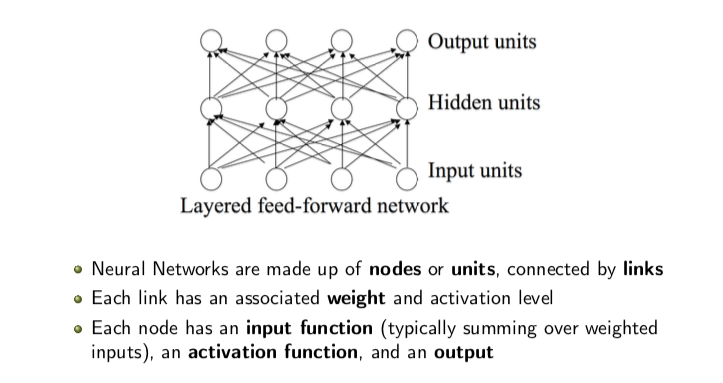


Let's start by implementing a Sigmoid unit.
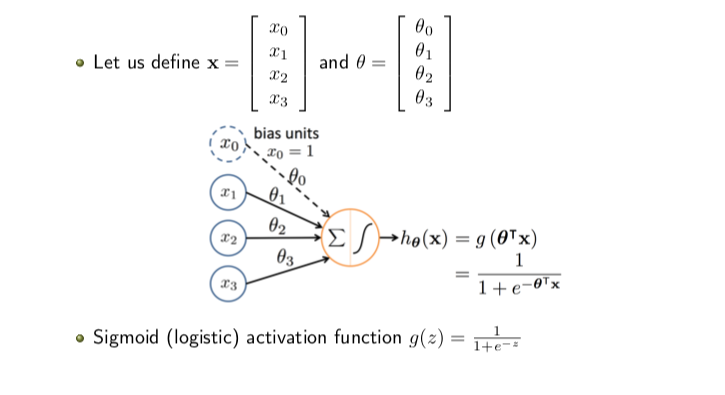

In [2]:
def logistic_function(z):
    return 1/(1 + np.exp(-z))


input_size = 10
x = np.random.randn(input_size)

thetas = np.random.randn(input_size + 1) # "+1" for the bias
x = np.append(x, 1) # x_0 == 1
input_function_result = np.dot(thetas, x)
activation_function_result = logistic_function(input_function_result)
output = activation_function_result

Let's rewrite it in a more convenient object oriented form.

In [3]:
class Linear:
    def __init__(self, input_size):
        self.thetas = np.random.randn(input_size + 1) # "+1" for the bias
    
    
    def forward(self, x):
        x = np.append(x, 1) # x_0 == 1
        output = np.dot(self.thetas, x)
        return output

    
class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output


input_size = 10
x = np.random.randn(input_size)

linear1 = Linear(input_size)
logistic1 = LogisticActivation()
logistic1.forward(linear1.forward(x))

0.6428791998559694

Our sigmoid unit is consists of a linear unit with logistic activation. Let's the lone Linear unit with a *fully connected* Linear layer.
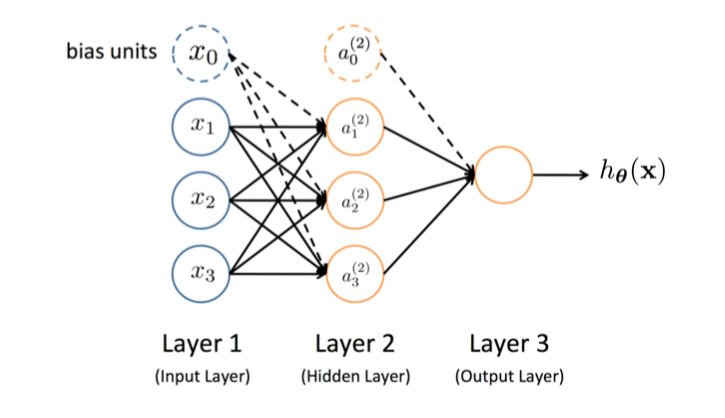

In [4]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = np.random.randn(output_size, input_size + 1) # "+1" for the bias
    
    
    def forward(self, x):
        x = np.append(x, 1) # x_0 == 1
        output = np.dot(self.thetas, x)
        return output


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output


input_size = 10
x = np.random.randn(input_size)

linear1 = Linear(input_size, 5)
logistic1 = LogisticActivation()

logistic1.forward(linear1.forward(x))

array([0.57340938, 0.54579819, 0.96788702, 0.88043746, 0.00791778])

Let's use these modules to build an MLP with one hidden layer for classification of MNIST digits.
We feed the NxN pixel images to our MLP in the form of 1D arrays of size N^2.
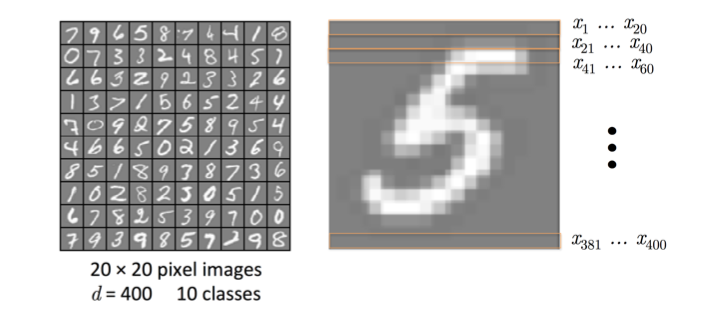
The output is a 10-element array with each element corresponding to one digit.
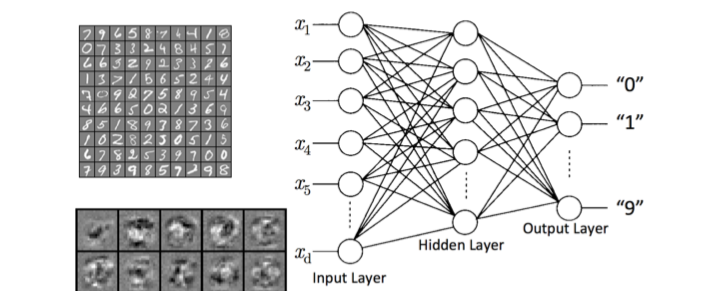
We use softmax $\frac{e^{z_i}}{\sum_k e^{z_k}}$ activation at the end to get the one-hot vector output.
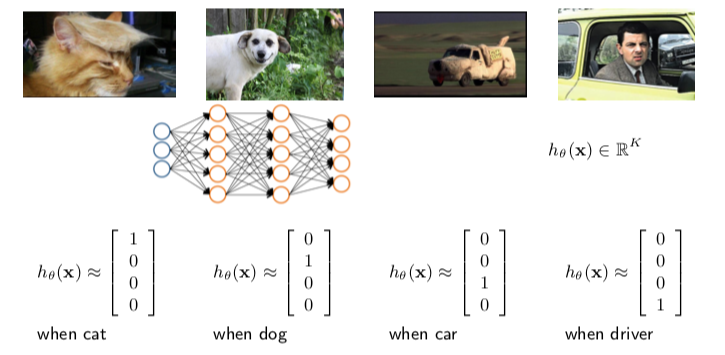

We will use the toy version of the dataset with ~2k 8x8 images, and will first select one digit to play with.

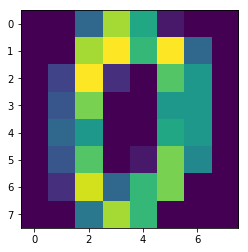

In [5]:
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

x = digits[0]
plt.imshow(x.reshape(8, 8))
y = 0

In [6]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = np.random.randn(output_size, input_size + 1) # "+1" for the bias
    
    
    def forward(self, x):
        x = np.append(x, 1) # x_0 == 1        
        output = np.dot(self.thetas, x)
        return output


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output
    

class SoftMaxActivation:
    def forward(self, x):
        output = np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)
        return output


hidden_layer_size = 100
linear1 = Linear(input_size, hidden_layer_size)
activation1 = LogisticActivation()
linear2 = Linear(hidden_layer_size, classes_n)
activation2 = SoftMaxActivation()

activation2.forward(linear2.forward(activation1.forward(linear1.forward(x)))).round()

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

Splendid! Our MLP formally works, but performs randomly since we didn't train it. To train it we need to implement backpropagation, but you will do this at home. Intstead, we will use the power of PyTorch and its auto-grad functionality for automatic backpropagation.

## Act 2: Multilayer perceptron on PyTorch
PyTorch tensors are similar to numpy arrays but may be used on GPU and automatically track the gradients for backpropagation. Let's first train our MLP to correctly classify our one selected digit, and then train it to correctly classify an arbitrary digit.

First, let's replace numpy arrays and functions with torch tensors.

The torch tensor store their data in the form of numpy arrays. To create a tensor with the data stored in an already existing numpy array and avoid the copy, use the [`torch.from_numpy`](https://pytorch.org/docs/master/torch.html#torch.from_numpy) function.

In [7]:
x = torch.from_numpy(x)

We make the following replacements:
1. `np.random.randn` → [`torch.randn`](https://pytorch.org/docs/master/torch.html#torch.randn),
2. `np.append` → [`torch.cat`](https://pytorch.org/docs/master/torch.html#torch.cat) with [`torch.ones`](https://pytorch.org/docs/master/torch.html#torch.ones),
2. `np.dot` → [`torch.matmul`](https://pytorch.org/docs/master/torch.html#torch.matmul),
2. `torch.exp` → [`torch.exp`](https://pytorch.org/docs/master/torch.html#torch.exp).

Note, that the interface of `torch` slightly differs from `numpy`, e.g `axis` and `keepdims` vs `dim` and `keepdim`.

In [8]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = torch.randn(output_size, input_size + 1) # "+1" for the bias
    
    
    def forward(self, x):
        x = torch.cat([x, torch.ones(1)]) # x_0 == 1
        output = torch.matmul(self.thetas, x)
        return output


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + torch.exp(-x))
        return output


class SoftMaxActivation:
    def forward(self, x):
        output = x.exp() / x.exp().sum(dim=-1, keepdim=True)
        return output


hidden_layer_size = 100
linear1 = Linear(input_size, hidden_layer_size)
activation1 = LogisticActivation()
linear2 = Linear(hidden_layer_size, classes_n)
activation2 = SoftMaxActivation()

activation2.forward(linear2.forward(activation1.forward(linear1.forward(x)))).round()

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Next, we need to define the loss function to measure the difference between the predicted and the true label. We will use the [`CrossEntropy`](https://pytorch.org/docs/stable/nn.html#crossentropyloss) loss, with wich we don't need the last activation.

In [9]:
criterion = torch.nn.CrossEntropyLoss()
prediction = linear2.forward(activation1.forward(linear1.forward(x)))

The `torch.nn` package only supports tensors with mini-batch dimension, which we will discuss in detail on the seminar on deep learning. For now, all you have to know is that we need to add an additional "fake" dimension. It can be done with [`torch.unsqueeze`](https://pytorch.org/docs/stable/torch.html#torch.unsqueeze)`(dim=0)`, which is equivalent to `numpy.ndarray[None]`.

In [10]:
prediction_w_minibatch = prediction.unsqueeze(0)
target = torch.tensor(y).unsqueeze(0)
criterion(prediction_w_minibatch, target)

tensor(8.9840)

To optimize the parameters of a neural network, we need to calculate the gradients of the loss function w.r.t these parameters and further perform a step of Gradient descent (or [another optimizer](http://ruder.io/optimizing-gradient-descent/index.html)).
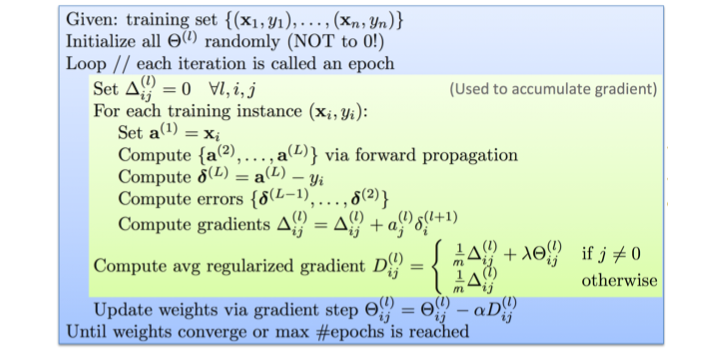

PyTorch can do this calculation automatically, we only need to specify that a certain tensor requires its gradient to be calcualted -- it is done via setting its `.requires_grad` attribute to `True` --, and then call `.backward()` on the loss function output.

Note, that the tensor, created as the result of transformation of a tensor with `.requires_grad == True`, automatically "requires grad".

In [11]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = torch.randn(output_size, input_size + 1, requires_grad=True) # "+1" for the bias
    
    
    def forward(self, x):
        x = torch.cat([x, torch.ones(1)]) # x_0 == 1
        output = torch.matmul(self.thetas, x)
        return output


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + torch.exp(-x))
        return output


hidden_layer_size = 100
linear1 = Linear(input_size, hidden_layer_size)
activation1 = LogisticActivation()
linear2 = Linear(hidden_layer_size, classes_n)

criterion = torch.nn.CrossEntropyLoss()
prediction_w_minibatch = linear2.forward(activation1.forward(linear1.forward(x))).unsqueeze(0)
target = torch.tensor(y).unsqueeze(0)
loss = criterion(prediction_w_minibatch, target)

loss.requires_grad

True

Finally, we are ready to train our MLP to correctly classify the one digit. The course of action is:
1. zero the gradients,
2. perform the forward pass, i.e predict,
3. calculate the loss and perform the backward pass,
4. update the weights of the network,
5. repeat until convergence.

We will use the implementation of Stochastic gradient descent from PyTorch [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD). We need to feed it an iterable over the tensors representing the parameters of the network, which in our case is `[linear1.thetas, linear2.thetas]`.

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<RoundBackward>)

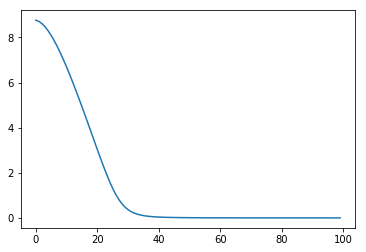

In [12]:
torch.manual_seed(0)


class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = torch.randn(output_size, input_size + 1, requires_grad=True) # "+1" for the bias
    
    
    def forward(self, x):
        x = torch.cat([x, torch.ones(1)]) # x_0 == 1
        output = torch.matmul(self.thetas, x)
        return output


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + torch.exp(-x))
        return output
    

class SoftMaxActivation:
    def forward(self, x):
        output = x.exp() / x.exp().sum(dim=-1, keepdim=True)
        return output


hidden_layer_size = 100
linear1 = Linear(input_size, hidden_layer_size)
activation1 = LogisticActivation()
linear2 = Linear(hidden_layer_size, classes_n)

target = torch.tensor(y).unsqueeze(0)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([linear1.thetas, linear2.thetas], lr=1e-3, momentum=0.9)

epochs_n = 100
learning_curve = [0] * epochs_n

for epoch in range(epochs_n):
    optimizer.zero_grad()
    
    prediction_w_minibatch = linear2.forward(activation1.forward(linear1.forward(x))).unsqueeze(0)
    
    loss = criterion(prediction_w_minibatch, target)
    learning_curve[epoch] = loss.item()
    loss.backward()
    
    optimizer.step() # basically, weight -= grad * learning_rate


plt.plot(learning_curve)
SoftMaxActivation().forward(linear2.forward(activation1.forward(linear1.forward(x)))).round()

Our MLP learned to correctly classify the one digit. Let's rewrite our MLP in a more concise way with the help of `torch.nn` package.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size=input_size, output_size=classes_n, hidden_layer_size=100):
        super().__init__()
        self.first_fully_connected = nn.Linear(input_size, hidden_layer_size)
        self.output_fully_connected = nn.Linear(hidden_layer_size, classes_n)


    def forward(self, x):
        x = torch.sigmoid(self.first_fully_connected(x))
        x = self.output_fully_connected(x)
        return x

It is now a `torch.nn.Module` with the linear layers as its attributes of the same class. The parameters of the network are incapsulated in the corresponding attributes in the form of `torch.nn.Parameter`, that 1) automatically require gradients

In [14]:
mlp = MLP()
mlp.first_fully_connected.weight

Parameter containing:
tensor([[ 0.0995, -0.0735,  0.0295,  ...,  0.0243,  0.0124,  0.0252],
        [-0.1155, -0.1202, -0.0518,  ..., -0.1169, -0.0922,  0.0452],
        [ 0.0519,  0.0648, -0.1150,  ..., -0.1048, -0.0567, -0.0589],
        ...,
        [-0.1024, -0.0747,  0.0920,  ...,  0.0563, -0.0417, -0.0874],
        [ 0.0395, -0.0049,  0.0780,  ..., -0.0400,  0.0105,  0.0036],
        [ 0.0460,  0.0152,  0.0322,  ..., -0.0422, -0.0513,  0.1011]],
       requires_grad=True)

and 2) automatically are registered as the parameters of the parent module, that we can pass to the optimizer.

In [15]:
next(mlp.parameters()) is mlp.first_fully_connected.weight

True

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<RoundBackward>)

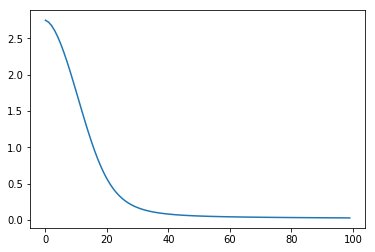

In [16]:
torch.manual_seed(0)


class MLP(nn.Module):
    def __init__(self, input_size=input_size, output_size=classes_n, hidden_layer_size=100):
        super().__init__()
        self.first_fully_connected = nn.Linear(input_size, hidden_layer_size)
        self.output_fully_connected = nn.Linear(hidden_layer_size, classes_n)


    def forward(self, x):
        x = torch.sigmoid(self.first_fully_connected(x))
        x = self.output_fully_connected(x)
        return x


mlp = MLP()

target = torch.tensor(y).unsqueeze(0)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9)

epochs_n = 100
learning_curve = [0] * epochs_n

for epoch in range(epochs_n):
    optimizer.zero_grad()
    
    prediction_w_minibatch = mlp(x).unsqueeze(0)
    
    loss = criterion(prediction_w_minibatch, target)
    learning_curve[epoch] = loss.item()
    loss.backward()
    
    optimizer.step() # basically, weight -= grad * learning_rate


plt.plot(learning_curve)
torch.softmax(mlp(x), dim=0).round()

Let's see, how it performs on the whole dataset.

In [17]:
all_x = torch.from_numpy(digits)
_, predictions = torch.max(mlp(all_x), -1)
pd.DataFrame(confusion_matrix(targets, predictions))

0  1  2  3  4  5  6  7  8  9
0  178  0  0  0  0  0  0  0  0  0
1  182  0  0  0  0  0  0  0  0  0
2  177  0  0  0  0  0  0  0  0  0
3  183  0  0  0  0  0  0  0  0  0
4  181  0  0  0  0  0  0  0  0  0
5  182  0  0  0  0  0  0  0  0  0
6  181  0  0  0  0  0  0  0  0  0
7  179  0  0  0  0  0  0  0  0  0
8  174  0  0  0  0  0  0  0  0  0
9  180  0  0  0  0  0  0  0  0  0

Neat! It thinks that everything is this one digit. Now let's train it on the whole dataset.

## Act 3: Classifying MNIST

First of all, let's try to train our MLP with Gradient descent instead of its stochastic version. That is, we average the gradients over the whole training dataset and then make an optimization step. The part of the optimization history during which the whole training set is processed is called *epoch*, so in this case the whole epoch is one step of the optimization algorithm.

After each epoch, we measure the performance of our MLP on the test data simply using the loss function. To prevent pytorch from performing wasteful backprop during the calculation of this test loss value, we use the [`torch.no_grad`](https://pytorch.org/docs/stable/autograd.html?highlight=no_grad#torch.autograd.no_grad) context-manager.

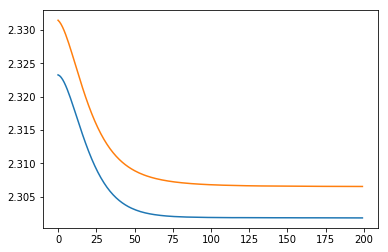

In [18]:
torch.manual_seed(1)


class MLP(nn.Module):
    def __init__(self, input_size=input_size, output_size=classes_n, hidden_layer_size=100):
        super().__init__()
        self.first_fully_connected = nn.Linear(input_size, hidden_layer_size)
        self.output_fully_connected = nn.Linear(hidden_layer_size, classes_n)


    def forward(self, x):
        x = torch.sigmoid(self.first_fully_connected(x))
        x = self.output_fully_connected(x)
        return x


mlp = MLP()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9)

epochs_n = 200
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = torch.from_numpy(digits_train)
x_test = torch.from_numpy(digits_test)
y_train = torch.from_numpy(targets_train)
y_test = torch.from_numpy(targets_test)

for epoch in range(epochs_n):
    x = x_train
    target = y_train
    
    optimizer.zero_grad()

    prediction_w_minibatch = mlp(x)

    loss = criterion(prediction_w_minibatch, target)
    learning_curve[epoch] = loss.item()
    loss.backward()

    optimizer.step()
    
    with torch.no_grad():
        prediction_w_minibatch = mlp(x_test)
        loss = criterion(prediction_w_minibatch, y_test)
        test_curve[epoch] = loss.item()


plt.plot(learning_curve)
plt.plot(test_curve)

It was fast. But what's the performance?

In [19]:
_, predictions = torch.max(mlp(all_x), -1)
pd.DataFrame(confusion_matrix(targets, predictions))

0  1  2  3    4  5  6  7  8  9
0  0  0  0  0  178  0  0  0  0  0
1  0  0  0  0  182  0  0  0  0  0
2  0  0  0  0  177  0  0  0  0  0
3  0  0  0  0  183  0  0  0  0  0
4  0  0  0  0  181  0  0  0  0  0
5  0  0  0  0  182  0  0  0  0  0
6  0  0  0  0  181  0  0  0  0  0
7  0  0  0  0  179  0  0  0  0  0
8  0  0  0  0  174  0  0  0  0  0
9  0  0  0  0  180  0  0  0  0  0

#### The question:
Why the performance is poor?

<font color='red'>The network is confused since at each iteration it is trained to correctly classify *the whole dataset*.</font>

#### The task:
Let's try Stochastic gradient descent, calculating the gradients for only one training sample at a time.

Starting epoch 0 Starting epoch 10 Starting epoch 20 Starting epoch 30 Starting epoch 40 Starting epoch 50 Starting epoch 60 Starting epoch 70 Starting epoch 80 Starting epoch 90 Starting epoch 100 Starting epoch 110 Starting epoch 120 Starting epoch 130 Starting epoch 140 Starting epoch 150 Starting epoch 160 Starting epoch 170 Starting epoch 180 Starting epoch 190 

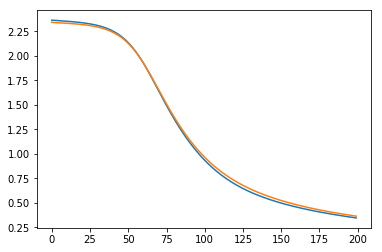

In [20]:
torch.manual_seed(0)

class MLP(nn.Module):
    def __init__(self, input_size=input_size, output_size=classes_n, hidden_layer_size=100):
        super().__init__()
        self.first_fully_connected = nn.Linear(input_size, hidden_layer_size)
        self.output_fully_connected = nn.Linear(hidden_layer_size, classes_n)


    def forward(self, x):
        x = torch.sigmoid(self.first_fully_connected(x))
        x = self.output_fully_connected(x)
        return x


mlp = MLP()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9)

epochs_n = 200
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = torch.from_numpy(digits_train)
x_test = torch.from_numpy(digits_test)
y_train = torch.from_numpy(targets_train)
y_test = torch.from_numpy(targets_test)

for epoch in range(epochs_n):
    if epoch % 10 == 0:
        print('Starting epoch {}'.format(epoch), end=' ')
    for sample_i in range(train_size):
        x = x_train[sample_i]
        target = y_train[sample_i:sample_i+1]
    
        optimizer.zero_grad()
    
        prediction_w_minibatch = mlp(x).unsqueeze(0)
    
        loss = criterion(prediction_w_minibatch, target)
        learning_curve[epoch] += loss.item()
        loss.backward()

        optimizer.step()
    
    with torch.no_grad():
        learning_curve[epoch] /= train_size
        prediction_w_minibatch = mlp(x_test)
        loss = criterion(prediction_w_minibatch, y_test)
        test_curve[epoch] = loss.item()


plt.plot(learning_curve)
plt.plot(test_curve)

In [21]:
_, predictions = torch.max(mlp(all_x), -1)
pd.DataFrame(confusion_matrix(targets, predictions))

0    1    2    3    4    5    6    7    8    9
0  174    0    0    0    2    1    1    0    0    0
1    0  152    6    1    2    0    7    0    2   12
2    0    7  163    6    0    0    0    1    0    0
3    0    0    2  172    0    3    0    3    2    1
4    0    4    0    0  170    0    2    4    1    0
5    0    0    0    1    1  177    0    0    0    3
6    1    2    0    0    0    0  178    0    0    0
7    0    0    0    0    1    2    0  174    1    1
8    0   22    2    7    1    7    1    2  126    6
9    0    1    0   10    4    3    0   10    2  150

Well, that was fun.